# Load & Preprocessing

In [15]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


fake_news_path = 'datasets/raza/Fake.csv'
true_news_path = 'datasets/raza/True.csv'

fake_news_df = pd.read_csv(fake_news_path)
true_news_df = pd.read_csv(true_news_path)

In [16]:
fake_news_df['label'] = 'Fake'
true_news_df['label'] = 'True'

combined_df = pd.concat([fake_news_df, true_news_df], ignore_index=True)

In [17]:
combined_df['label'].value_counts()

label
Fake    23481
True    21417
Name: count, dtype: int64

# EDA

In [10]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return words

fake_news_words = combined_df[combined_df['label'] == 'Fake']['text'].astype(str).apply(preprocess_text).explode()
true_news_words = combined_df[combined_df['label'] == 'True']['text'].astype(str).apply(preprocess_text).explode()

fake_news_word_counts = Counter(fake_news_words)
true_news_word_counts = Counter(true_news_words)

print("Most Common Words in Fake News:")
print(fake_news_word_counts.most_common(15))
print("\nMost Common Words in True News:")
print(true_news_word_counts.most_common(15))

Most Common Words in Fake News:
[('trump', 73422), ('said', 31008), ('people', 25941), ('president', 25495), ('would', 23420), ('one', 22865), ('us', 22005), ('clinton', 17957), ('obama', 17760), ('like', 17596), ('donald', 17101), ('also', 15221), ('new', 14135), ('news', 14099), ('even', 13658)]

Most Common Words in True News:
[('said', 99017), ('trump', 42061), ('us', 40847), ('would', 31418), ('reuters', 28306), ('president', 25223), ('state', 18547), ('government', 17851), ('new', 16712), ('house', 16294), ('states', 16063), ('also', 15935), ('united', 15566), ('republican', 15273), ('people', 14604)]


In [12]:
fake_news_count = fake_news_word_counts.most_common(100)
true_news_count = true_news_word_counts.most_common(100)

differences =[]
for word, count in fake_news_count:
    if word not in dict(true_news_count):
        differences.append((word, count))

In [14]:
print(fake_news_count)

[('trump', 73422), ('said', 31008), ('people', 25941), ('president', 25495), ('would', 23420), ('one', 22865), ('us', 22005), ('clinton', 17957), ('obama', 17760), ('like', 17596), ('donald', 17101), ('also', 15221), ('new', 14135), ('news', 14099), ('even', 13658), ('hillary', 13510), ('white', 12767), ('time', 12689), ('state', 12494), ('via', 11164), ('media', 10980), ('get', 10689), ('campaign', 10565), ('house', 10545), ('america', 10523), ('know', 10256), ('could', 10189), ('first', 9977), ('american', 9920), ('going', 9741), ('many', 9690), ('image', 9572), ('states', 9457), ('make', 9143), ('told', 9100), ('republican', 8976), ('right', 8709), ('made', 8662), ('country', 8640), ('government', 8579), ('police', 8527), ('say', 8507), ('way', 8427), ('back', 8356), ('think', 8319), ('two', 8307), ('years', 8212), ('united', 7964), ('election', 7949), ('video', 7810), ('last', 7794), ('may', 7623), ('political', 7545), ('party', 7440), ('black', 7436), ('want', 7283), ('see', 7254)

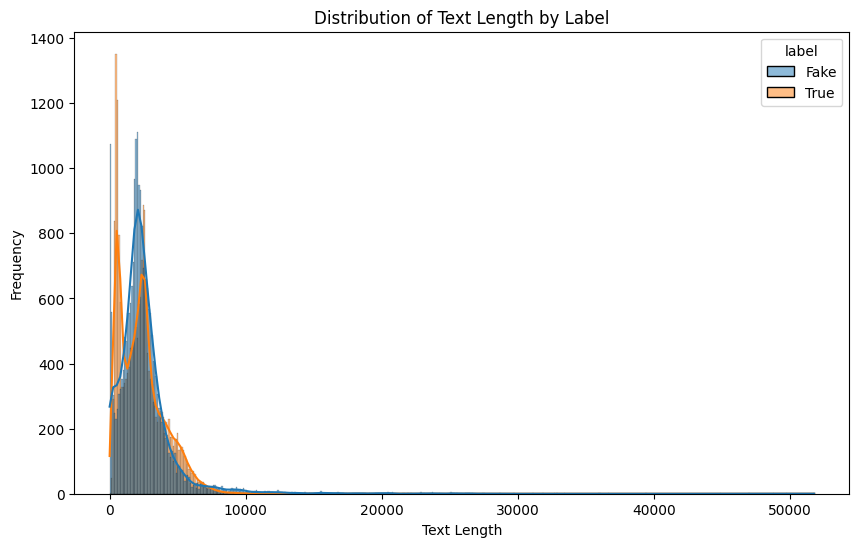


Descriptive Statistics of Text Length by Label:
         count         mean          std  min     25%     50%     75%      max
label                                                                         
Fake   23481.0  2547.396235  2532.884399  1.0  1433.0  2166.0  3032.0  51794.0
True   21417.0  2383.278517  1684.835730  1.0   914.0  2222.0  3237.0  29781.0


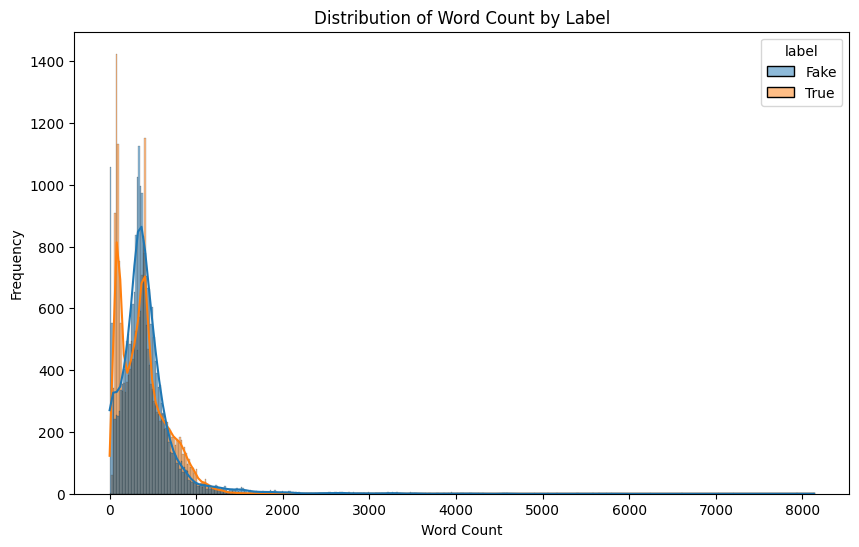


Descriptive Statistics of Word Count by Label:
         count        mean         std  min    25%    50%    75%     max
label                                                                   
Fake   23481.0  423.197905  408.388890  0.0  240.0  363.0  506.0  8135.0
True   21417.0  385.640099  274.006204  0.0  148.0  359.0  525.0  5172.0


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of the length of the news articles
combined_df['text_length'] = combined_df['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(combined_df, x='text_length', hue='label', kde=True)
plt.title('Distribution of Text Length by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

print("\nDescriptive Statistics of Text Length by Label:")
print(combined_df.groupby('label')['text_length'].describe())

# Distribution of the number of words in the news articles
combined_df['word_count'] = combined_df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(combined_df, x='word_count', hue='label', kde=True)
plt.title('Distribution of Word Count by Label')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

print("\nDescriptive Statistics of Word Count by Label:")
print(combined_df.groupby('label')['word_count'].describe())

# SVM

## Train Model

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Combine 'title' and 'text' columns
combined_df['combined_text'] = combined_df['title'].fillna('') + ' ' + combined_df['text'].fillna('')

# Prepare the data
X = combined_df['combined_text']
y = combined_df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data into numerical vectors using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train the Support Vector Machine (SVM) classifier
svm_classifier = LinearSVC()
svm_classifier.fit(X_train_tfidf, y_train)



LinearSVC()

In [26]:
svm_classifier.coef_.shape

(1, 111609)

## Predict and calculate metrics

Accuracy on the Test Set: 0.9953


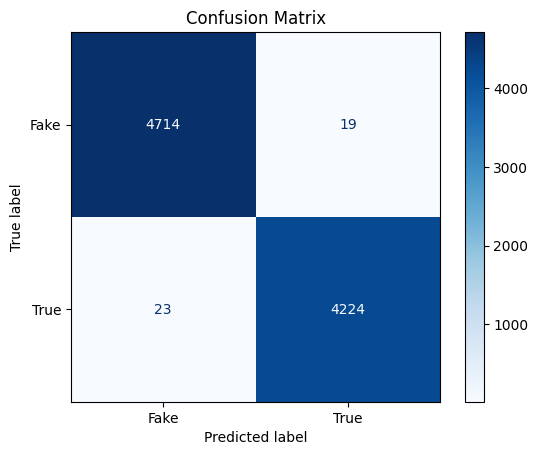


Class-wise Performance (based on normalized confusion matrix):
Percentage of correctly predicted 'Fake' news: 0.9960
Percentage of correctly predicted 'True' news: 0.9946

The 'Fake' class was predicted better than the 'True' class.

The 'True' class was predicted worse than the 'Fake' class.


In [19]:
# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_tfidf)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the Test Set: {accuracy:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Fake', 'True'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'True'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Analyze which class is predicted better and worse
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, None]

fake_accuracy = cm_normalized[0, 0]
true_accuracy = cm_normalized[1, 1]

print("\nClass-wise Performance (based on normalized confusion matrix):")
print(f"Percentage of correctly predicted 'Fake' news: {fake_accuracy:.4f}")
print(f"Percentage of correctly predicted 'True' news: {true_accuracy:.4f}")

if fake_accuracy > true_accuracy:
    print("\nThe 'Fake' class was predicted better than the 'True' class.")
elif true_accuracy > fake_accuracy:
    print("\nThe 'True' class was predicted better than the 'Fake' class.")
else:
    print("\nThe prediction performance for both classes is similar.")

# Identify which class is predicted worse (higher misclassification rate)
fake_misclassification = 1 - fake_accuracy
true_misclassification = 1 - true_accuracy

if fake_misclassification > true_misclassification:
    print("\nThe 'Fake' class was predicted worse than the 'True' class.")
elif true_misclassification > fake_misclassification:
    print("\nThe 'True' class was predicted worse than the 'Fake' class.")
else:
    print("\nThe misclassification rate is similar for both classes.")

In [20]:
# Create a DataFrame with the test data and predictions
predictions_df = pd.DataFrame({'text': X_test, 'actual_label': y_test, 'predicted_label': y_pred})

# Filter for false positives (Fake classified as True)
false_positives = predictions_df[(predictions_df['actual_label'] == 'Fake') & (predictions_df['predicted_label'] == 'True')]

# Filter for false negatives (True classified as Fake)
false_negatives = predictions_df[(predictions_df['actual_label'] == 'True') & (predictions_df['predicted_label'] == 'Fake')]

print("\nExamples of False Positives (Fake News Classified as True):\n")
if not false_positives.empty:
    for index, row in false_positives.head(5).iterrows():
        print(f"Text: {row['text'][:200]}...")
        print(f"Actual Label: {row['actual_label']}")
        print(f"Predicted Label: {row['predicted_label']}")
        print("-" * 50)
else:
    print("No false positives found.")

print("\nExamples of False Negatives (True News Classified as Fake):\n")
if not false_negatives.empty:
    for index, row in false_negatives.head(5).iterrows():
        print(f"Text: {row['text'][:200]}...")
        print(f"Actual Label: {row['actual_label']}")
        print(f"Predicted Label: {row['predicted_label']}")
        print("-" * 50)
else:
    print("No false negatives found.")


Examples of False Positives (Fake News Classified as True):

Text:  Energy Department To Close Office Of International Climate And Technology In response to the U.S. withdrawing from the Paris climate agreement earlier this month, the Energy Department is shutting do...
Actual Label: Fake
Predicted Label: True
--------------------------------------------------
Text: PALESTINIANS STEPPING UP STABBINGS: Dramatic Video Shows Palestinian Man Stabbing Israeli Police Officers…Israeli Teen Stabbed On Bicycle ***Warning*** Graphic photo and videoThank goodness Israeli s ...
Actual Label: Fake
Predicted Label: True
--------------------------------------------------
Text: N. KOREA’S LATEST MISSILE LAUNCH Aimed At Testing Carrying “Large Scale Heavy Nuclear Warhead” North Korea said on Monday it had successfully conducted a newly developed mid-to-long range missile test...
Actual Label: Fake
Predicted Label: True
--------------------------------------------------
Text: BREAKING: Republican Major

## Validate model in different dataset

In [21]:
dataset_path = 'datasets/WELFake_Dataset.csv'
combined_df2 = pd.read_csv(dataset_path)
combined_df2['label'] = combined_df2['label'].replace({0: 'Fake', 1: 'True'})
combined_df2 = combined_df2.dropna()

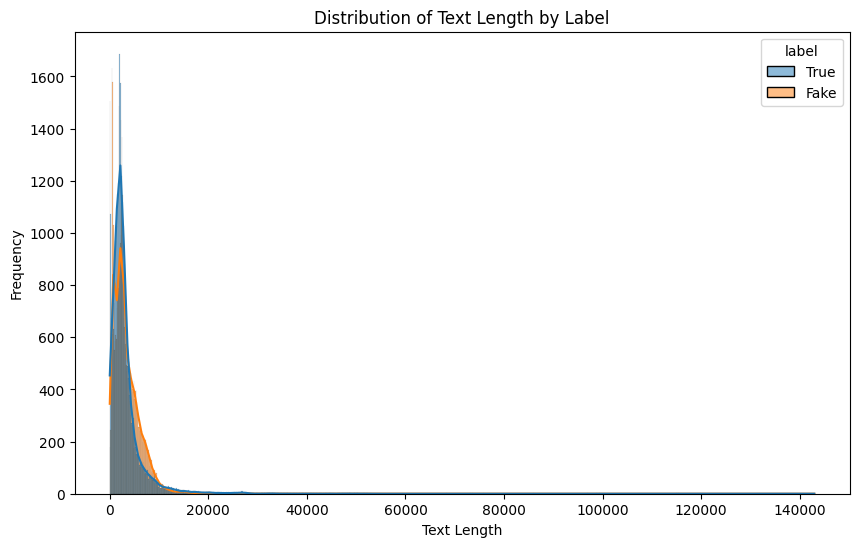


Descriptive Statistics of Text Length by Label:
         count        mean          std  min     25%     50%      75%  \
label                                                                   
Fake   35028.0  3495.31669  3325.498668  1.0  1477.0  2642.5  4757.25   
True   36509.0  3098.34586  4085.854738  1.0  1364.0  2235.0  3456.00   

            max  
label            
Fake    85948.0  
True   142961.0  


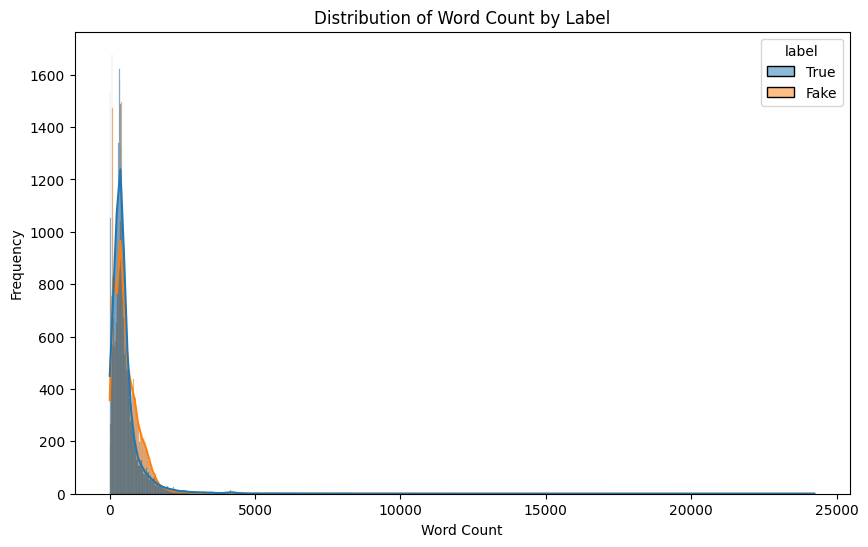


Descriptive Statistics of Word Count by Label:
         count        mean         std  min    25%    50%    75%      max
label                                                                    
Fake   35028.0  577.615536  563.115638  0.0  241.0  427.0  783.0  14641.0
True   36509.0  512.850886  680.010437  0.0  225.0  373.0  573.0  24234.0


In [20]:
combined_df2 = combined_df2.dropna(subset=['text'])
combined_df2['text_length'] = combined_df2['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(combined_df2, x='text_length', hue='label', kde=True)
plt.title('Distribution of Text Length by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

print("\nDescriptive Statistics of Text Length by Label:")
print(combined_df2.groupby('label')['text_length'].describe())

# Distribution of the number of words in the news articles
combined_df2['word_count'] = combined_df2['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(combined_df2, x='word_count', hue='label', kde=True)
plt.title('Distribution of Word Count by Label')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

print("\nDescriptive Statistics of Word Count by Label:")
print(combined_df2.groupby('label')['word_count'].describe())

In [24]:
# Combine 'title' and 'text' columns
combined_df2['combined_text'] = combined_df2['title'].fillna('') + ' ' + combined_df2['text'].fillna('')

# Prepare the data
X = combined_df2['combined_text']
y = combined_df2['label']

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data into numerical vectors using TF-IDF
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf2 = tfidf_vectorizer.transform(X_train2)
X_test_tfidf2 = tfidf_vectorizer.transform(X_test2)

Accuracy on the Test Set: 0.1699


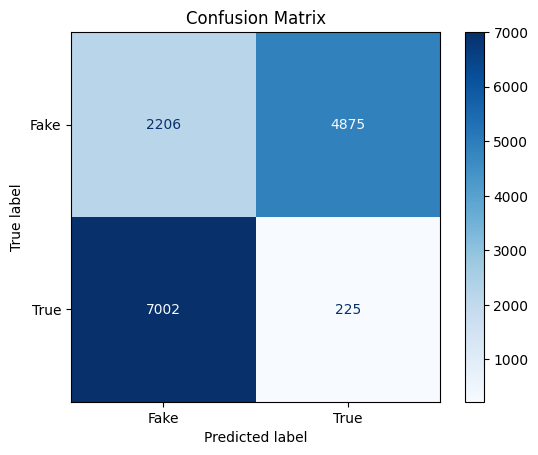


Class-wise Performance (based on normalized confusion matrix):
Percentage of correctly predicted 'Fake' news: 0.3115
Percentage of correctly predicted 'True' news: 0.0311

The 'Fake' class was predicted better than the 'True' class.

The 'True' class was predicted worse than the 'Fake' class.


In [25]:
# Make predictions on the test set
y_pred2 = svm_classifier.predict(X_test_tfidf2)

# Calculate the accuracy
accuracy2 = accuracy_score(y_test2, y_pred2)
print(f"Accuracy on the Test Set: {accuracy2:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(y_test2, y_pred2, labels=['Fake', 'True'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'True'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Analyze which class is predicted better and worse
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, None]

fake_accuracy = cm_normalized[0, 0]
true_accuracy = cm_normalized[1, 1]

print("\nClass-wise Performance (based on normalized confusion matrix):")
print(f"Percentage of correctly predicted 'Fake' news: {fake_accuracy:.4f}")
print(f"Percentage of correctly predicted 'True' news: {true_accuracy:.4f}")

if fake_accuracy > true_accuracy:
    print("\nThe 'Fake' class was predicted better than the 'True' class.")
elif true_accuracy > fake_accuracy:
    print("\nThe 'True' class was predicted better than the 'Fake' class.")
else:
    print("\nThe prediction performance for both classes is similar.")

# Identify which class is predicted worse (higher misclassification rate)
fake_misclassification = 1 - fake_accuracy
true_misclassification = 1 - true_accuracy

if fake_misclassification > true_misclassification:
    print("\nThe 'Fake' class was predicted worse than the 'True' class.")
elif true_misclassification > fake_misclassification:
    print("\nThe 'True' class was predicted worse than the 'Fake' class.")
else:
    print("\nThe misclassification rate is similar for both classes.")